In [2]:
import timm
# timm.list_models(pretrained=True)
import stereo
from stereo.utils import common_utils
from easydict import EasyDict
from stereo.modeling import models
from stereo.datasets.dataset_template import build_transform_by_cfg
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt
import time
import numpy as np
# import torch_tensorrt
import cv2

import open3d as o3d
# o3d.visualization.webrtc_server.enable_webrtc()


In [41]:
device = 'cpu' if not torch.backends.mps.is_available() else 'mps:0'

CFG_FILE = "./OpenStereo/cfgs/lightstereo/lightstereo_l_sceneflow.yaml"
# CFG_FILE = "/home/vamsik1211/Data/personal-projects/Robot-Vision-Project/stereo-depth-mapping/OpenStereo/cfgs/psmnet/psmnet_sceneflow.yaml"
# left_image_path = "/home/vamsik1211/Data/personal-projects/Robot-Vision-Project/stereo-depth-mapping/skiboots1/im0.png"
# right_image_path = "/home/vamsik1211/Data/personal-projects/Robot-Vision-Project/stereo-depth-mapping/skiboots1/im1.png"
yaml_config = common_utils.config_loader(CFG_FILE)
cfgs = EasyDict(yaml_config)
transform_config = cfgs.DATA_CONFIG.DATA_TRANSFORM.EVALUATING

# trainer = build_trainer(cfgs)

transform = build_transform_by_cfg(transform_config)
model = models.lightstereo.lightstereo.LightStereo(cfgs.MODEL)
model_weights = torch.load("./models/LightStereo-L-SceneFlow.ckpt", map_location=device, weights_only=True)

model.load_state_dict(model_weights['model_state'])


# model = models.psmnet.psmnet.PSMNet(cfgs.MODEL)

# model = torch.compile(model)




Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


<All keys matched successfully>

In [42]:
torch.backends.mps.is_available()

True

In [43]:


# device = 'cpu' if not torch.cuda.is_available() else 'cuda'
base_path = "./middleburry_dataset/data/artroom1/"
left_image_path = f"{base_path}/im0.png"
right_image_path = f"{base_path}/im1.png"

left_img = np.array(Image.open(left_image_path).convert('RGB'), dtype=np.float32)
right_img = np.array(Image.open(right_image_path).convert('RGB'), dtype=np.float32)

sample = {
    'left': left_img,
    'right': right_img
}
sample = transform(sample)
sample['left'] = sample['left'].unsqueeze(0)
sample['right'] = sample['right'].unsqueeze(0)

model.eval()
model.to(device)
for k, v in sample.items():
    sample[k] = v.to(device) if torch.is_tensor(v) else v



Time taken:  0.9790630340576172


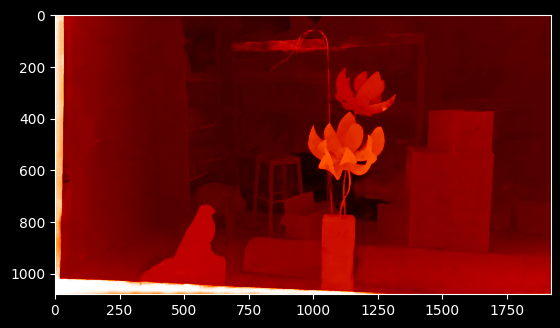

In [52]:

with torch.no_grad():
        with torch.amp.autocast(device_type=device, enabled=cfgs.OPTIMIZATION.AMP):
            torch.compiler.cudagraph_mark_step_begin()
            start = time.time()
            model_pred = model(sample)
            disp_pred = model_pred['disp_pred'].squeeze(1)
            print("Time taken: ", time.time() - start)

disparity = disp_pred.cpu().squeeze().numpy().astype(np.uint8)
plt.imshow(disparity,'gist_heat')
plt.show()


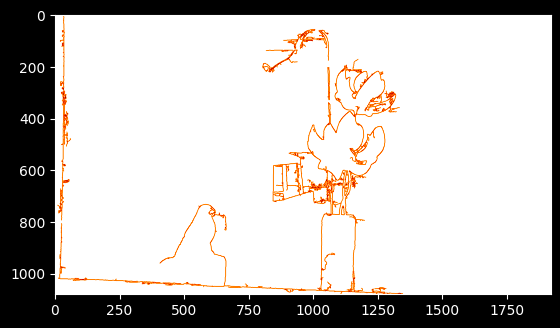

In [58]:
# Identify the edges in the left image
disparity = disp_pred.cpu().squeeze().numpy().astype(np.uint8)

threshold_img = cv2.adaptiveThreshold(disparity, disparity.max(), cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
edges = cv2.Canny(disparity.astype(np.uint8), 0, 255)
edges = np.where(edges < 255, 1, 0).astype(np.uint8)

# Apply closing operation to the edges
kernel = np.ones((2, 2), np.uint8)  # Define the kernel size
edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

threshold_img = np.where(threshold_img < 187, 0, 1).astype(np.uint8)

disparity = disparity * edges
disparity = np.where(disparity <=0, np.finfo(float).eps, disparity)

# Display the edges in the disparity map
plt.imshow(edges, cmap='gist_heat')
plt.show()

In [26]:
edges_closed.sum()

2073442

In [27]:
# disparity = disp_pred.cpu().squeeze().numpy()

In [59]:

def read_pfm(file):
    with open(file, 'rb') as f:
        # Read the header
        header = f.readline().decode('utf-8').rstrip()
        if header == 'PF':
            color = True
        elif header == 'Pf':
            color = False
        else:
            raise Exception('Not a PFM file.')

        # Read the dimensions
        dim_line = f.readline().decode('utf-8').rstrip()
        width, height = map(int, dim_line.split())

        # Read the scale factor
        scale = float(f.readline().decode('utf-8').rstrip())
        if scale < 0:  # little-endian
            endian = '<'
            scale = -scale
        else:
            endian = '>'

        # Read the pixel data
        data = np.fromfile(f, endian + 'f')
        shape = (height, width, 3) if color else (height, width)

        # Reshape the data
        data = np.reshape(data, shape)
        data = np.flipud(data)

        return data, scale


(1080, 1920)


3.4385872

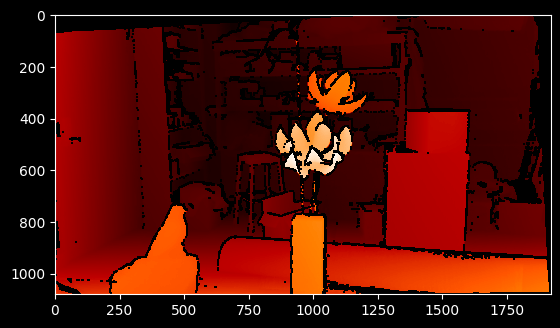

In [60]:

# Example usage
pfm_file = f'{base_path}/disp1.pfm'
image, scale = read_pfm(pfm_file)
print(image.shape)
plt.imshow(image, 'gist_heat')
(image/16).min() 

In [61]:
image

array([[       inf,        inf,        inf, ...,        inf,        inf,
               inf],
       [       inf,        inf,        inf, ...,        inf,        inf,
               inf],
       [       inf,        inf,        inf, ...,        inf,        inf,
               inf],
       ...,
       [105.220985, 105.22231 , 105.22798 , ...,        inf,        inf,
               inf],
       [105.352554, 105.34923 , 105.35929 , ...,        inf,        inf,
               inf],
       [105.47556 , 105.47556 , 105.47772 , ...,        inf,        inf,
               inf]], dtype=float32)

In [62]:
# example calib.txt
# cam0=[1733.74 0 792.27; 0 1733.74 541.89; 0 0 1]
# cam1=[1733.74 0 792.27; 0 1733.74 541.89; 0 0 1]
# doffs=0
# baseline=536.62
# width=1920
# height=1080
# ndisp=170
# vmin=55
# vmax=142


In [63]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import time

# imgL_color = cv2.imread('mc0.png')
# imgR_color = cv2.imread('mc1.png') 

# imgL = cv2.imread('mc0.png', cv2.IMREAD_GRAYSCALE)
# imgR = cv2.imread('mc1.png', cv2.IMREAD_GRAYSCALE)

# imgL_color = cv2.imread('skiboots1/im0.png')
# imgR_color = cv2.imread('skiboots1/im1.png') 

# imgL = cv2.imread('skiboots1/im0.png', cv2.IMREAD_GRAYSCALE)
# imgR = cv2.imread('skiboots1/im1.png', cv2.IMREAD_GRAYSCALE)

imgL = cv2.cvtColor(left_img.astype(np.uint8), cv2.COLOR_BGR2GRAY)
imgR = cv2.cvtColor(right_img.astype(np.uint8), cv2.COLOR_BGR2GRAY)


# scale_factor = 1/1
# imgL_color = cv2.resize(imgL_color, (0, 0), fx=scale_factor, fy=scale_factor)
# imgR_color = cv2.resize(imgR_color, (0, 0), fx=scale_factor, fy=scale_factor)
# imgL = cv2.resize(imgL, (0, 0), fx=scale_factor, fy=scale_factor)
# imgR = cv2.resize(imgR, (0, 0), fx=scale_factor, fy=scale_factor)



# baseline = 0.53662 # mm meters

# imgL = 

with open(f"{base_path}/calib.txt", 'r') as f:
    lines = f.readlines()
    for line in lines:
        if "baseline" in line:
            baseline = float(line.split("=")[1])
        if "ndisp" in line:
            ndisp = int(line.split("=")[1])
        if "vmin" in line:
            vmin = int(line.split("=")[1])
        if "vmax" in line:
            vmax = int(line.split("=")[1])
        if "width" in line:
            width = int(line.split("=")[1])
        if "height" in line:
            height = int(line.split("=")[1])
        if "cam0" in line:
            line = line.split('=')[1].strip().rstrip(']')
            rows = line.strip('[').split(';')
            # rows = line.strip().split(';')
            print(line)
            cam0 = [list(map(float, row.strip().split())) for row in rows]

        if "cam1" in line:
            line = line.split('=')[1].strip().rstrip(']')
            rows = line.strip('[').split(';')
            print(line)
            cam1 = [list(map(float, row.strip().split())) for row in rows]

        


window_size = 4
min_disp = 0
# nDispFactor = 32
max_disp = ndisp + 30

num_disp = ((max_disp - min_disp)//16)*16

# stereo = cv2.StereoBM_create()
# stereo.setMinDisparity(min_disp)
# stereo.setNumDisparities(num_disp)
# stereo.setDisp12MaxDiff(33)
# stereo.setBlockSize(11)
# stereo.setSpeckleRange(5)
# stereo.setSpeckleWindowSize(5)
# stereo.setUniquenessRatio(5)
# stereo.setPreFilterCap(32)
# stereo.setTextureThreshold(11)



# stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
#                                  numDisparities = num_disp,
#                                     blockSize = 11,
#                                     P1 = 8*3*window_size**2,
#                                     P2 = 32*3*window_size**2,
#                                     disp12MaxDiff = 1,
#                                     uniquenessRatio = 10,
#                                     speckleWindowSize = 100,
#                                     speckleRange = 32,
#                                     preFilterCap = 10,
#                                     mode = cv2.StereoSGBM_MODE_SGBM_3WAY
#                                )

# stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
#                                  numDisparities = num_disp,
#                                     blockSize = 11,
#                                     P1 = 8*3*window_size**2,
#                                     P2 = 32*3*window_size**2,
#                                     disp12MaxDiff = 1,
#                                     uniquenessRatio = 1,
#                                     speckleWindowSize = 100,
#                                     speckleRange = 32,
#                                     preFilterCap = 10,
#                                     mode = cv2.StereoSGBM_MODE_SGBM_3WAY
#                                )

start = time.time()
# disparity = disp_pred.cpu().squeeze().numpy()
# disparity = stereo.compute(imgL,imgR)

# disparity = (disparity/16 - min_disp) / max_disp

# disparity = np.clip(disparity, np.finfo(float).eps, 255)
end = time.time()
print("Time: ", end-start)



import open3d as o3d

# o3d_img = o3d.geometry.Image(imgL_color)
# o3d_depth = o3d.geometry.Image(disparity)


# rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(o3d_img, o3d_depth, convert_rgb_to_intensity = False)

focal_length = cam0[0][0]
cx_L = cam0[0][2]
cy_L = cam0[1][2]

cx_R = cam1[0][2]
cy_R = cam1[1][2]
# baseline = 0.193 # mm meters
baseline = baseline/1000
# baseline = 0.67837 # mm meters
# baseline = 0.22113
# focal_length = 1733.68

# cx_L = 819.72
# cy_L = 957.55
# cx_L = 1244.772
# cy_L = 1019.507

# cx_R = 819.72
# cy_R = 957.55
# cx_R = 1369.115
# cy_R = 1019.507

camera_intrinsic_L = o3d.camera.PinholeCameraIntrinsic(
    width=width,  # Replace with your image width
    height=height, # Replace with your image height
    fx=focal_length,   # Replace with your camera's focal length in x
    fy=focal_length,   # Replace with your camera's focal length in y
    cx=cx_L,   # Replace with your camera's principal point in x
    cy=cy_L    # Replace with your camera's principal point in y
)

camera_intrinsic_R = o3d.camera.PinholeCameraIntrinsic(
    width=width,  # Replace with your image width
    height=height, # Replace with your image height
    fx=focal_length,   # Replace with your camera's focal length in x
    fy=focal_length,   # Replace with your camera's focal length in y
    cx=cx_R,   # Replace with your camera's principal point in x
    cy=cy_R    # Replace with your camera's principal point in y
)

# focal_length = 1733.74

depth = (focal_length * baseline) / (disparity)

# depth_bl = cv2.bilateralFilter(depth, d=4, sigmaColor=75, sigmaSpace=75)
# # depth_median = cv2.medianBlur(depth, ksize=13)
# depth_avg = cv2.blur(depth, ksize=(20, 20))  # ksize is the size of the kernel

# # sharpen_kernel = np.array([[-1, -1, -1],
# #                            [-1,  2, -1],
# #                            [-1, -1, -1]])
# sharpen_kernel = np.array([[-1, 1, -1], [0, 5, 0], [0, 1, 0]])
# # sharpen_kernel = np.array([[2, 0], [0, 2]])
# depth_sharpened = cv2.filter2D(depth, -1, sharpen_kernel)


# fig, axes = plt.subplots(2, 2, figsize=(18, 10))
# axes[0][0].imshow(depth, cmap='gist_heat')
# axes[0][0].set_title('Original Depth Map')
# # axes[0][0].axis('off')

# axes[0][1].imshow(depth_bl, cmap='gist_heat')
# axes[0][1].set_title('Bilinear Depth Map')
# # axes[0][1].axis('off')

# axes[1][0].imshow(depth_avg, cmap='gist_heat')
# axes[1][0].set_title('Averaged Depth Map')
# # axes[1][0].axis('off')

# axes[1][1].imshow(depth_sharpened, cmap='gist_heat')
# axes[1][1].set_title('Sharpened Depth Map')
# # axes[1][1].axis('off')

# plt.show()
# plt.imshow(depth,'gist_heat')
# plt.imshow(depth_bl, 'gist_heat')
# plt.show()

# Convert images to Open3D format
# imgL_color = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)

# depth = image

o3d_img = o3d.geometry.Image(left_img.astype(np.uint8))
o3d_depth = o3d.geometry.Image(depth.astype(np.float32))

rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(o3d_img, o3d_depth, convert_rgb_to_intensity=False)

pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, camera_intrinsic_L)

# Create the point cloud
# pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
#     rgbd, camera_intrinsic
# )

[1733.74 0 792.27; 0 1733.74 541.89; 0 0 1
[1733.74 0 792.27; 0 1733.74 541.89; 0 0 1
Time:  1.0013580322265625e-05


In [64]:
depth_sharpened

NameError: name 'depth_sharpened' is not defined

In [13]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, camera_intrinsic_L)

In [43]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                    #   zoom=0.3412,
                                    #   front=[0.4257, -0.2125, -0.8795],
                                    #   lookat=[2.6172, 2.0475, 1.532],
                                    #   up=[-0.0694, -0.9768, 0.2024])
    )

In [35]:
# voxel_down_pcd = pcd.voxel_down_sample(voxel_size=0.00001)

cl, ind = pcd.remove_statistical_outlier(nb_neighbors=20,
                                                    std_ratio=2.0)

display_inlier_outlier(pcd, ind)

Showing outliers (red) and inliers (gray): 
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [32]:
type(voxel_down_pcd), type(pcd)

(open3d.cpu.pybind.geometry.PointCloud, open3d.cpu.pybind.geometry.PointCloud)

In [ ]:
cl, ind = pcd.remove_radius_outlier(nb_points=16, radius=0.05)

# inlier_cloud = pcd.select_by_index(ind)


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [65]:

o3d.visualization.draw_geometries([pcd],)

# o3d.visualization.draw_geometries([pcd])


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [14]:
import cv2

vcap = cv2.VideoCapture("http://192.168.239.28:8889/cam")
while True:
    ret, frame = vcap.read()
    if not ret:
        break
    cv2.imshow('VIDEO', frame)
    # Wait for the Enter key (ASCII value 13)
    if cv2.waitKey(0) == 13:
        continue
    else:
        break

vcap.release()
cv2.destroyAllWindows()

OpenCV: Couldn't read video stream from file "http://192.168.239.28:8889/cam"


In [1]:
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined

In [ ]:
# read cv2 camera from rstp
cap = cv2.VideoCapture("rtsp://")

(False, None)

In [2]:
import cv2
import asyncio
from aiortc import RTCPeerConnection, RTCSessionDescription
from aiortc.contrib.media import MediaPlayer

async def run(pc, player):
    @pc.on("track")
    def on_track(track):
        print("Track %s received" % track.kind)

        if track.kind == "video":
            @track.on("frame")
            def on_frame(frame):
                img = frame.to_ndarray(format="bgr24")
                cv2.imshow("VIDEO", img)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    return

    await pc.setRemoteDescription(RTCSessionDescription(sdp, type))
    await pc.addTrack(player.video)

    await asyncio.sleep(3600)  # Run for 1 hour

if __name__ == "__main__":
    pc = RTCPeerConnection()
    player = MediaPlayer("http://192.168.239.28:8189/cam")

    # Replace 'sdp' and 'type' with your SDP and type
    sdp = "your_sdp_here"
    type = "offer"  # or "answer"

    loop = asyncio.get_event_loop()
    loop.run_until_complete(run(pc, player))

[tcp @ 0x15fe59c40] Connection to tcp://192.168.239.28:8189 failed: Connection refused


ConnectionRefusedError: [Errno 61] Connection refused: 'http://192.168.239.28:8189/cam'